In [1]:
import pandas as pd
import warnings
import xarray as xr
import ephem
from datetime import datetime, timedelta
import math
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt

from myconfig import *
output_path = output_path_buoy_data


In [2]:
station = '41043'
fname = 'https://www.ndbc.noaa.gov/data/realtime2/'+station+'.txt'
#more info: https://www.ndbc.noaa.gov/station_page.php?station=41043. 10 min intervals

In [3]:
df_buoy = pd.read_csv(fname, delim_whitespace=True, header=0, parse_dates=True,na_values='MM')
#delete units row
df_buoy = df_buoy.drop(index=0)
df_buoy.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
1,2024,10,17,22,50,90,7.0,8.0,1.5,7,5.2,108,1014.2,29.7,NaN,26.4,NaN,NaN,NaN
2,2024,10,17,22,40,90,7.0,8.0,1.5,NaN,5.2,108,1014.1,29.7,30.5,26.1,NaN,NaN,NaN
3,2024,10,17,22,30,90,7.0,8.0,NaN,NaN,NaN,NaN,1014.1,29.7,30.5,26.3,NaN,NaN,NaN
4,2024,10,17,22,20,90,7.0,9.0,1.5,7,5.4,106,1014.0,29.7,NaN,26.5,NaN,NaN,NaN
5,2024,10,17,22,10,90,7.0,9.0,1.5,NaN,5.4,106,1014.0,29.7,30.5,26.4,NaN,NaN,NaN


In [4]:
# Rename columns to match expected input for to_datetime
df_buoy.rename(columns={"#YY": "year", "MM": "month", "DD": "day", "hh": "hour", "mm": "minute"}, inplace=True)

# Combine the date and time columns into a single timestamp
df_buoy['Timestamp'] = pd.to_datetime(df_buoy[['year', 'month', 'day', 'hour', 'minute']])

df_clean_buoy = df_buoy.drop(columns=['year', 'month', 'day', 'hour', 'minute', 'DPD', 'MWD', 'PRES', 'DEWP', 'VIS', 'PTDY', 'TIDE']).drop(index=1)
#df_clean_buoy.dtypes


In [5]:
# Get the current date and calculate the threshold for the last 7 days
seven_days_ago = datetime.now() - timedelta(days=7)

# Filter the DataFrame to only keep rows from the last 7 days
df_last_7_days = df_clean_buoy[df_clean_buoy['Timestamp'] >= seven_days_ago]

df_last_7_days

,WDIR,WSPD,GST,WVHT,APD,ATMP,WTMP,Timestamp
2,90,7.0,8.0,1.5,5.2,29.7,30.5,2024-10-17 22:40:00
3,90,7.0,8.0,NaN,NaN,29.7,30.5,2024-10-17 22:30:00
4,90,7.0,9.0,1.5,5.4,29.7,NaN,2024-10-17 22:20:00
5,90,7.0,9.0,1.5,5.4,29.7,30.5,2024-10-17 22:10:00
6,90,7.0,9.0,NaN,NaN,29.7,30.5,2024-10-17 22:00:00
...,...,...,...,...,...,...,...,...
1035,200,5.0,7.0,NaN,NaN,30.0,30.5,2024-10-10 17:00:00
1036,200,5.0,6.0,1.9,8.7,30.1,30.5,2024-10-10 16:50:00
1037,190,5.0,6.0,NaN,NaN,30.0,30.5,2024-10-10 16:40:00
1038,190,5.0,7.0,NaN,NaN,30.0,30.5,2024-10-10 16:30:00


In [6]:
#reverse the data
df_reversed_clean_buoy = df_last_7_days.iloc[::-1].reset_index(drop=True)
#df_last_1800 = df_reversed_clean_buoy.tail(1800).copy()

columns_to_convert = ['WDIR', 'WSPD', 'GST', 'WVHT', 'APD', 'ATMP', 'WTMP']

# Convert specified columns to float, using 'coerce' to handle errors
df_reversed_clean_buoy[columns_to_convert] = df_reversed_clean_buoy[columns_to_convert].apply(pd.to_numeric, errors='coerce')

df_reversed_clean_buoy = df_reversed_clean_buoy.reset_index(drop=True)
df_reversed_clean_buoy = df_reversed_clean_buoy.interpolate(method='linear', limit_direction='both')
df_reversed_clean_buoy.head()

,WDIR,WSPD,GST,WVHT,APD,ATMP,WTMP,Timestamp
0,200.0,5.0,7.0,2.000000,8.7,30.0,30.5,2024-10-10 16:20:00
1,190.0,5.0,7.0,1.966667,8.7,30.0,30.5,2024-10-10 16:30:00
2,190.0,5.0,6.0,1.933333,8.7,30.0,30.5,2024-10-10 16:40:00
3,200.0,5.0,6.0,1.900000,8.7,30.1,30.5,2024-10-10 16:50:00
4,200.0,5.0,7.0,1.950000,8.6,30.0,30.5,2024-10-10 17:00:00


In [7]:
df_reversed_clean_buoy.shape

(1038, 8)

In [8]:
# Function to calculate sunlight for each timestamp
def calculate_sunlight(lat, lon, timestamps):
    # Initialize observer
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)

    # Initialize the Sun object
    sun = ephem.Sun()

    # Store results
    sunlight_data = []

    for timestamp in timestamps:
        observer.date = timestamp

        # Compute the position of the sun for the observer at the given time
        sun.compute(observer)

        # Altitude is in degrees (-90 to 90), where 90 is zenith and 0 is on the horizon
        altitude = sun.alt

        # Normalize sunlight (1 for zenith, 0 for horizon, and negative for below horizon)
        normalized_sunlight = max(0, altitude / ephem.degree)

        sunlight_data.append(normalized_sunlight)

    return pd.DataFrame({'timestamp': timestamps, 'sunlight_fraction': sunlight_data})

# Latitude and longitude for the given location
lat, lon =  19.71361111111111, -67.31083333333333

timestamps = df_reversed_clean_buoy['Timestamp']

# Calculate sunlight fraction for the entire time range
sunlight_df = calculate_sunlight(lat, lon, timestamps)

In [9]:
df_reversed_clean_buoy["sun_exposure"] = sunlight_df["sunlight_fraction"]

In [10]:
#add glitter trough

from scipy.interpolate import CubicSpline

# Define the function to generate the smooth symmetrical two peaks and trough normalized curve
def generate_smooth_symmetric_two_peaks_trough_normalized(n):
    key_positions = [0, 1, 5, 9, 10]  # Symmetrical positions with the trough in the center (at 5)
    key_values = [0, 1, 0.33, 1, 0]  # Corresponding values for start, peaks, trough, and end
    
    # Use cubic spline for smooth interpolation
    spline_interpolator = CubicSpline(key_positions, key_values, bc_type=((1, 0), (1, 0)))

    # Generate evenly spaced positions for n steps
    new_positions = np.linspace(0, 10, n)

    # Generate interpolated values with the cubic spline
    smooth_values = spline_interpolator(new_positions)

    # Normalize the result to range 0-1
    normalized_values = (smooth_values - smooth_values.min()) / (smooth_values.max() - smooth_values.min())

    return pd.DataFrame(normalized_values, columns=['Normalized Symmetrical Two Peaks and Trough'])

# Function to apply the spline curve to an interval
def apply_spline_to_interval(df, start, end):
    n = end - start + 1
    print(end,start,n)
    # Generate the smooth curve
    spline_df = generate_smooth_symmetric_two_peaks_trough_normalized(n)
    
    # Multiply sun exposure in the interval by the spline values
    df.loc[start:end, 'sun_exposure_modified'] = df.loc[start:end, 'sun_exposure'] * spline_df.values.flatten()

# Add a shifted column to detect changes in sun exposure
df_reversed_clean_buoy['sun_exposure_shift'] = df_reversed_clean_buoy['sun_exposure'].shift(1)

# Find the start and end of intervals where sun exposure transitions from 0 to >0 and back to 0
start_intervals = df_reversed_clean_buoy[(df_reversed_clean_buoy['sun_exposure_shift'] == 0) & (df_reversed_clean_buoy['sun_exposure'] > 0)].index
end_intervals = df_reversed_clean_buoy[(df_reversed_clean_buoy['sun_exposure_shift'] > 0) & (df_reversed_clean_buoy['sun_exposure'] == 0)].index

print(start_intervals)
print(end_intervals)
print('***** GREG CHECK *** reversed start/end below')

# Pair up the start and end intervals
#intervals = list(zip(start_intervals, end_intervals))
intervals = list(zip(end_intervals, start_intervals))

# Apply the spline modification to all intervals
for start, end in intervals:
    apply_spline_to_interval(df_reversed_clean_buoy, start, end)

df_reversed_clean_buoy['sun_exposure_modified'].fillna(0.0, inplace=True)
df_reversed_clean_buoy['sun_exposure_shift']=df_reversed_clean_buoy.sun_exposure_shift[1]

# Display the first few rows of the modified DataFrame
df_reversed_clean_buoy.head(5)


Index([107, 249, 391, 533, 677, 821, 964], dtype='int64')
Index([35, 177, 319, 461, 603, 747, 891, 1034], dtype='int64')
***** GREG CHECK *** reversed start/end below
107 35 73
249 177 73
391 319 73
533 461 73
677 603 75
821 747 75
964 891 74


,WDIR,WSPD,GST,WVHT,APD,ATMP,WTMP,Timestamp,sun_exposure,sun_exposure_shift,sun_exposure_modified
0,200.0,5.0,7.0,2.000000,8.7,30.0,30.5,2024-10-10 16:20:00,63.270672,63.270672,0.0
1,190.0,5.0,7.0,1.966667,8.7,30.0,30.5,2024-10-10 16:30:00,63.066197,63.270672,0.0
2,190.0,5.0,6.0,1.933333,8.7,30.0,30.5,2024-10-10 16:40:00,62.641031,63.270672,0.0
3,200.0,5.0,6.0,1.900000,8.7,30.1,30.5,2024-10-10 16:50:00,62.005229,63.270672,0.0
4,200.0,5.0,7.0,1.950000,8.6,30.0,30.5,2024-10-10 17:00:00,61.172759,63.270672,0.0


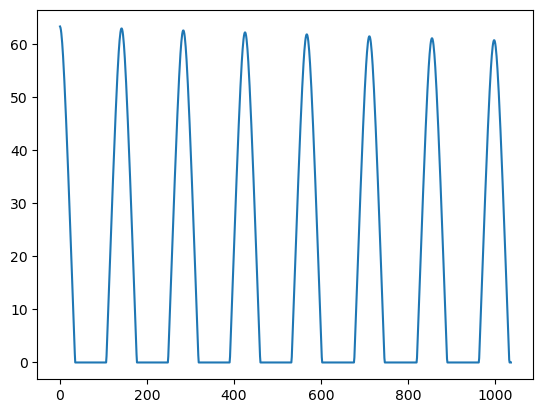

In [11]:
plt.plot(df_reversed_clean_buoy.sun_exposure)

In [12]:
new_index = np.linspace(0, len(df_reversed_clean_buoy) - 1, 7200)

df = df_reversed_clean_buoy
df_interpolated = pd.DataFrame()
for var in df.columns:
    if var=='Timestamp':
        continue
    df_interpolated[var] = np.interp(new_index, np.arange(len(df)), df[var])
# Interpolate 'timestamp' column onto the new index (if you want to interpolate timestamps too)
df_interpolated['Timestamp'] = pd.to_datetime(np.interp(new_index, np.arange(len(df)), df['Timestamp'].astype(int)))
df_interpolated['Timestamp'] = pd.to_datetime(df_interpolated['Timestamp'])
#print(df_interpolated.sun_exposure[0:20])

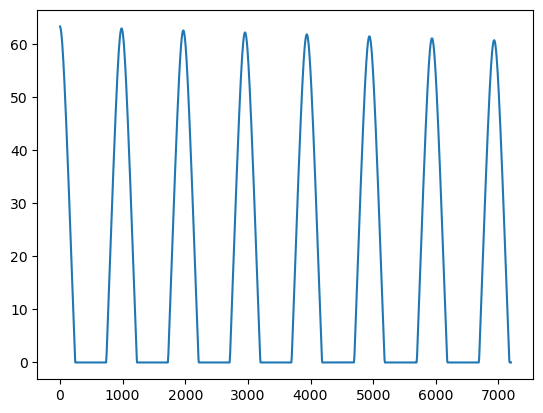

In [13]:
plt.plot(df_interpolated.sun_exposure)
#df_expanded.sun_exposure[60:120]

In [14]:
#normalize and park
# Assuming 'df' is already loaded and has the 'Sample' column
# Normalize the 'Sample' column using min-max normalization
df = df_interpolated
vars = ['WDIR','WSPD','GST','WVHT','APD','ATMP','WTMP']
df_normalized = df
for var in vars:
    df_normalized[var] = (df[var] - np.min(df[var])) / (np.max(df[var]) - np.min(df[var]))
# Display the resulting DataFrame (showing first and last 10 rows)
df_normalized.head(3), df_normalized.tail(3)

(       WDIR      WSPD  GST      WVHT       APD      ATMP      WTMP  \
 0  0.551558  0.556148  0.6  0.611111  0.857143  0.723968  0.364645   
 1  0.546876  0.556148  0.6  0.608444  0.857143  0.723968  0.364645   
 2  0.542195  0.556148  0.6  0.605776  0.857143  0.723968  0.364645   
 
    sun_exposure  sun_exposure_shift  sun_exposure_modified  \
 0     63.270672           63.270672                    0.0   
 1     63.241218           63.270672                    0.0   
 2     63.211763           63.270672                    0.0   
 
                       Timestamp  
 0 2024-10-10 16:20:00.000000000  
 1 2024-10-10 16:21:26.428670720  
 2 2024-10-10 16:22:52.857341184  ,
           WDIR      WSPD  GST      WVHT       APD      ATMP      WTMP  \
 7197  0.194042  0.778607  0.7  0.333333  0.148737  0.620417  0.364645   
 7198  0.194042  0.778607  0.7  0.333333  0.145797  0.620417  0.364645   
 7199  0.194042  0.778607  0.7  0.333333  0.142857  0.620417  0.364645   
 
       sun_exposure  

In [15]:
new_order = ['Timestamp','WDIR', 'WSPD', 'GST', 'WVHT', 'APD', 'ATMP', 'WTMP', 
       'sun_exposure', 'sun_exposure_shift', 'sun_exposure_modified']
new_df = df_normalized[new_order]
fname = output_path + 'buoy_nrt.csv'
new_df.to_csv(fname, index = False)

In [16]:
#plt.plot(new_df.sun_exposure)